In [27]:
from common.transformations.camera import transform_img, eon_intrinsics
from common.transformations.model import medmodel_intrinsics, model_intrinsics, bigmodel_intrinsics, \
calmodel_intrinsics, sbigmodel_intrinsics

import numpy as np
from tqdm import tqdm

from tensorflow.keras.models import load_model
from tools.lib.parser import parser
import sys
from utils import frames_to_tensor

import cv2
from tools.lib.framereader import FrameReader
from tools.lib.logreader import LogReader
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [28]:
hao_model = load_model('pretrain_model.keras')

In [29]:
fr = FrameReader('/home/hao/highway_cong_drives/stop-and-go/2019-11-01--16-06-48--30/fcamer.hevc')
lr = LogReader('/home/hao/highway_cong_drives/stop-and-go/2019-11-01--16-06-48--30/rlog.bz2')
logs = list(lr)
true_speed_hist = [l.carState.vEgo for l in logs if l.which() == 'carState']
model_hist = [l.model for l in logs if l.which() == 'model']

In [30]:
# figsize(12,6)
true_speed_list = [l.carState.vEgo for l in logs if l.which() == 'carState']
true_speed_list = [true_speed_list[i] for i in range(6000) if i%5==0]
# plot(true_speed_list, linewidth=3)
# title('Car speed from raw logs (m/s)', fontsize=12)
# xlabel('boot time (s)', fontsize=12)
# ylabel('speed (m/s)', fontsize=12)

**Camera intrinsics are important? Let's try different size of focusing view**


Here med and big means how large area OP is looking at.Bigmodel uses the full image, which has potential to stop before traffic lights

In [31]:
to_intrinsic = medmodel_intrinsics # model_intrinsics, bigmodel_intrinsics, \calmodel_intrinsics, sbigmodel_intrinsics

In [32]:
# ~~~~~~~~~~~~ initialize first frame and hidden rnn state ~~~~~~~~~~~~~~~~~~~~~~~~ #
frame =  fr.get(0, pix_fmt='rgb24')[0]
img_yuv = cv2.cvtColor(frame, cv2.COLOR_BGR2YUV_I420).reshape((874*3//2, 1164))
model_frame = transform_img(img_yuv, from_intr=eon_intrinsics, to_intr=to_intrinsic, yuv=True,
                                    output_size=(512,256))
rnn_state = np.zeros((1,512))
desire = np.zeros((1,8)) # no lane changes
traffic_convention = np.zeros((1,2)) # no traffic lights or other traffic conventions

model_speed = []
for i in tqdm(range(1200)):
    frame_index = i
    try:
        new_frame = fr.get(frame_index, pix_fmt='rgb24')[0]
        new_img_yuv = cv2.cvtColor(new_frame, cv2.COLOR_BGR2YUV_I420).reshape((874*3//2, 1164))
        new_model_frame = transform_img(new_img_yuv, from_intr=eon_intrinsics, to_intr=to_intrinsic, yuv=True,
                                    output_size=(512,256))
        two_frames = [model_frame, new_model_frame] # two consecutive model frames to the neural net 
        model_frame = new_model_frame ## update the current model frame
        ### prepare sending input to the NN
        frame_tensors = frames_to_tensor(np.array(two_frames)).astype(np.float32)/128.0 - 1.0
        net_inputs = [np.vstack(frame_tensors)[None], desire, rnn_state]
        net_outputs = hao_model.predict(net_inputs)
        rnn_state = net_outputs[-1]
#         print('True speed is {}, model predicts vEgo {}, at frame step {}'.format(np.round(true_speed_hist[frame_index*5],2),\
#                                                                                           np.round(net_outputs[5][0][0],2),frame_index))
        model_speed.append(net_outputs[5][0])
    except:
        print('Error: cannot get new frame ',str(frame_index))

100%|██████████| 1200/1200 [01:11<00:00, 16.81it/s]

Error: cannot get new frame  1199


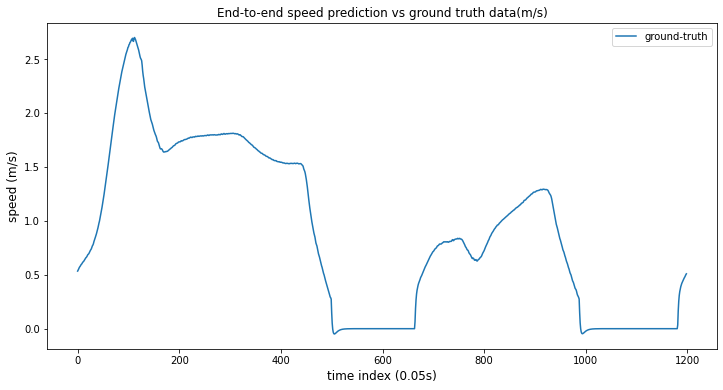

In [34]:
scale = 1.0
model_speed = [speed*scale for speed in model_speed]
figsize(12,6)
# plot(model_speed[1:],label='model_predict')
plot(true_speed_list[1:],label='ground-truth')

title('End-to-end speed prediction vs ground truth data(m/s)', fontsize=12)
xlabel('time index (0.05s)', fontsize=12)
ylabel('speed (m/s)', fontsize=12)
legend()

### Model predictive speed is derived using the first value in the future speed vector output by the model. Note that model predictive speed might not be a good indicator to show how well the model predicts.  

Now we compare the true future speed and the predicted future speed vector in stop-and-go traffic

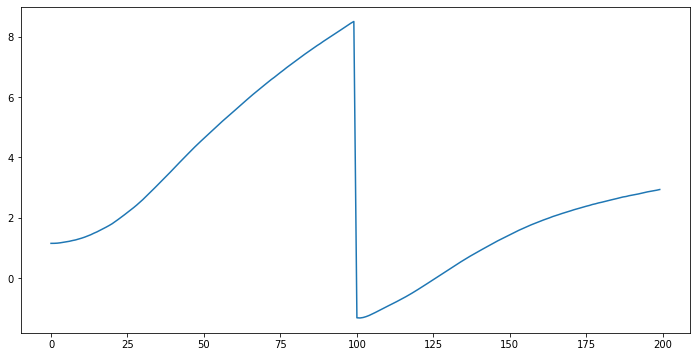

In [41]:
plt.plot(model_speed[200]) # 2 seconds 

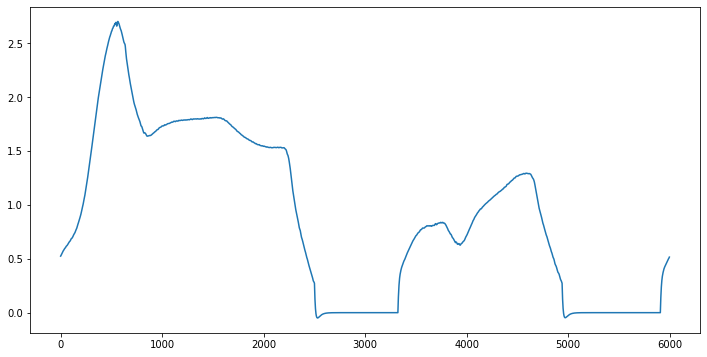

In [52]:
true_speed_hist = [l.carState.vEgo for l in logs if l.which() == 'carState']
plot(true_speed_hist)

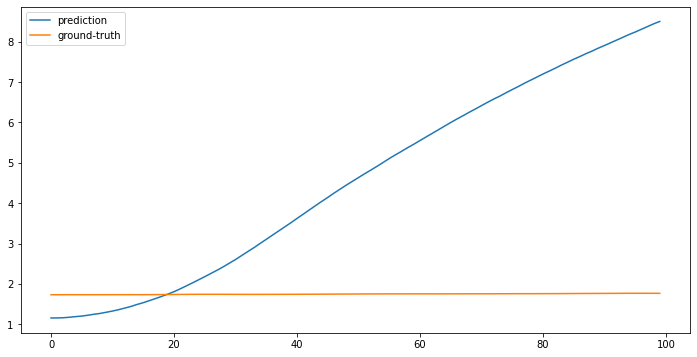

In [50]:
# show the predicted speed in the coming 1 second
# 200 means the index at 200 camera frame, each frame has 0.05 seconds 
index = 200
plt.plot(model_speed[index][:100],label='prediction')
plt.plot(true_speed_hist[index*5:index*5+100],label='ground-truth')
plt.legend()
# the predicted speed vector has an interval of 0.01s, so it has 100 points for 1 second prediction horizon 

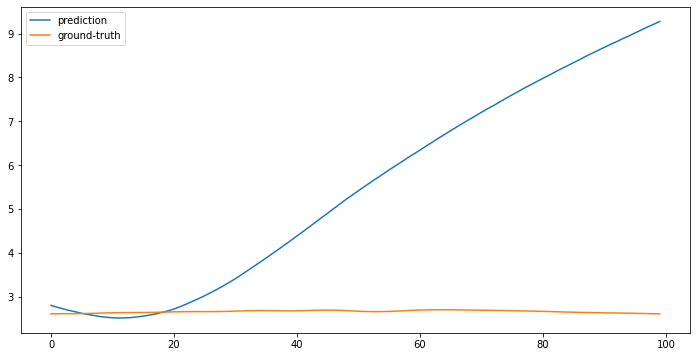

In [51]:
index = 100
plt.plot(model_speed[index][:100],label='prediction')
plt.plot(true_speed_hist[index*5:index*5+100],label='ground-truth')
plt.legend()